# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [3]:
from matplotlib.colors import BoundaryNorm

In [4]:
import matplotlib.lines as mlines

In [5]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [6]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [7]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [8]:
varname_plot = ['WRF_T2', 'WRF_T', 'WRF_precip', 'WRF_SPD10', 'WRF_SPD', 'WRF_PWAT', 'WRF_Q_tot']

dict_clim = {}

for exp_name in ['B3H', 'B6H', 'GDAS', 'target']:
    if exp_name == 'target':
        fn = '/glade/campaign/ral/hap/ksha/GWC_results/scores/clim/target_mean.zarr'
    else:
        fn = f'/glade/campaign/ral/hap/ksha/GWC_results/scores/clim/final_{exp_name}_mean.zarr'

    ds = xr.open_zarr(fn)
    
    for varname in varname_plot:
        dict_clim[f'{exp_name}_{varname}'] = ds[varname].values
        

In [9]:
static_name = '/glade/derecho/scratch/ksha/DWC_data/CONUS_domain_GP/static/C404_GP_static.zarr'
ds_static = xr.open_zarr(static_name)
lon_WRF = ds_static['XLONG'].values
lat_WRF = ds_static['XLAT'].values

## Plot

In [10]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [11]:
# line_keys = {}
# line_keys['B3H'] = {'linewidth': 3, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 3, 'label': ''}
# line_keys['B6H'] = {'linewidth': 3, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 4, 'label': ''}
# line_keys['GDAS'] = {'linewidth': 3, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 2, 'label': ''}
# line_keys['target'] = {'linewidth': 2.5, 'linestyle': '--', 'color': 'k', 'alpha': 1, 'zorder': 1, 'label': ''}

In [12]:
scale_param = '50m'

PROVINCE = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale=scale_param,
    facecolor='none')

def map_gridline_opt(ax):
    '''
    Customize cartopy map gridlines
    '''
    # lat/lon gridlines and labeling
    # GL = ax.gridlines(crs=ccrs.PlateCarree(), 
    #                   draw_labels=False, x_inline=False, y_inline=False, 
    #                   color='k', linewidth=0.1, linestyle=':', zorder=5)
    # GL.top_labels = None; GL.bottom_labels = None
    # GL.right_labels = None; GL.left_labels = None
    # GL.xlabel_style = {'size': 14}; GL.ylabel_style = {'size': 14}
    # GL.rotate_labels = False
    ax.add_feature(cfeature.BORDERS.with_scale(scale_param), linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(PROVINCE, edgecolor='k', linestyle='-', linewidth=1.5, zorder=7)
    ax.add_feature(cfeature.COASTLINE.with_scale(scale_param ), edgecolor='k', linewidth=1.5, zorder=5)
    ax.spines['geo'].set_linewidth(2.5)
    return ax

In [13]:
lon_line = lon_WRF[150, :]
lat_line = lat_WRF[150, :]
plevel = np.array([1000, 946, 915, 867, 800, 715, 610, 500, 420, 280, 180, 100])
gridx, gridy = np.meshgrid(lon_line, plevel)

In [14]:
# print(lon_line[::90])
# print(lat_line[::90])

In [15]:
lon_range = np.array([lon_line.min(), lon_line.max()])
lat_range = np.array([lat_line.min(), lat_line.max()])

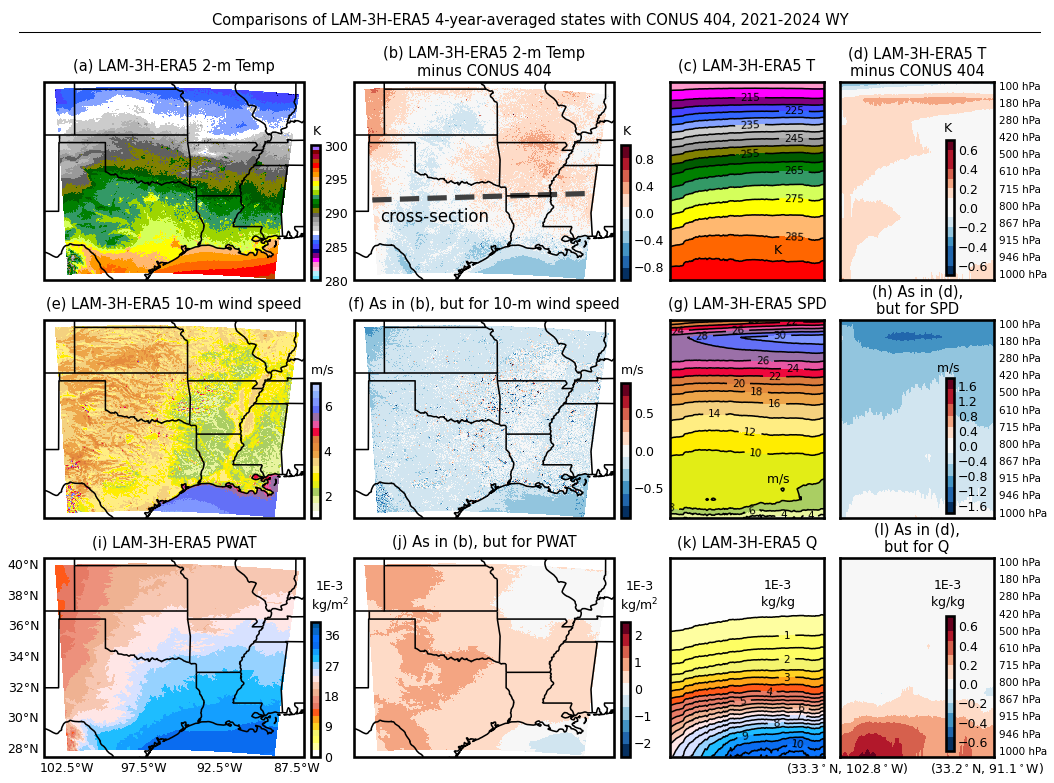

In [16]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

clabel_fmt_base = {'WRF_T': '%.0f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}
clabel_fmt_diff = {'WRF_T': '%.1f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}

dict_LIMs = {'WRF_T2': [280, 300], 'WRF_SPD10': [1, 7], 'WRF_PWAT': [0, 0.04]}
dict_diff_LIMs = {'WRF_T2': [-1, 1], 'WRF_SPD10': [-0.9, 0.9], 'WRF_PWAT': [-0.0025, 0.0025]}
dict_levels = {'WRF_T': np.arange(195, 315, 5), 'WRF_SPD': np.arange(0, 38, 2), 'WRF_Q_tot': np.arange(0, 0.012+0.0005, 0.0005)}
dict_diff_levels = {'WRF_T': np.arange(-0.7, 0.8, 0.1), 'WRF_SPD': np.arange(-1.8, 1.9, 0.1), 'WRF_Q_tot': np.arange(-0.0007, 0.00075, 0.00005)}

dict_CMAPs = {'WRF_T2': cmaps.t2m_29lev, 'WRF_T': cmaps.t2m_29lev, 'WRF_SPD10': cmaps.wind_17lev, 'WRF_SPD': cmaps.wind_17lev, 'WRF_PWAT': cmaps.rh_19lev, 'WRF_Q_tot': cmaps.rh_19lev}
dict_diff_CMAPs = {'WRF_T2': cmaps.CBR_coldhot, 'WRF_T': cmaps.CBR_coldhot, 'WRF_SPD10': cmaps.CBR_coldhot, 'WRF_SPD': cmaps.CBR_coldhot, 'WRF_PWAT': cmaps.CBR_coldhot, 'WRF_Q_tot': cmaps.CBR_coldhot}

dict_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}
dict_diff_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}

exp_name = 'B3H'
exp_name_print = 'LAM-3H-ERA5'

fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(5, 7, height_ratios=[1, 0.2, 1, 0.2, 1], width_ratios=[1, 0.001, 1, 0.1, 0.5, 0.05, 0.5])

AX_maps = []
AX_lines = []

AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 0], projection=proj_))

AX_maps.append(plt.subplot(gs[0, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 2], projection=proj_))


AX_lines.append(plt.subplot(gs[0, 4]))
AX_lines.append(plt.subplot(gs[2, 4]))
AX_lines.append(plt.subplot(gs[4, 4]))

AX_lines.append(plt.subplot(gs[0, 6]))
AX_lines.append(plt.subplot(gs[2, 6]))
AX_lines.append(plt.subplot(gs[4, 6]))

# AX_midline = plt.subplot(gs[:, 3])
# AX_midline.axvline(0.7, ymin=0, ymax=1.1, lw=2.5, color='k')

title_maps = [
    f'(a) {exp_name_print} 2-m Temp', 
    f'(e) {exp_name_print} 10-m wind speed',
    f'(i) {exp_name_print} PWAT',
    f'(b) {exp_name_print} 2-m Temp\nminus CONUS 404', 
    f'(f) As in (b), but for 10-m wind speed',
    f'(j) As in (b), but for PWAT'
]

title_lines = [
    f'(c) {exp_name_print} T', 
    f'(g) {exp_name_print} SPD',
    f'(k) {exp_name_print} Q',
    f'(d) {exp_name_print} T\nminus CONUS 404', 
    f'(h) As in (d),\nbut for SPD',
    f'(l) As in (d),\nbut for Q'
]

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if '\n' in title_maps[i_ax]:
        ax.set_title(title_maps[i_ax], fontsize=14)
    else:
        ax.set_title(title_maps[i_ax], fontsize=14, y=1.025)


i_ax = 2
ax = AX_maps[i_ax]
    
GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color=None, linewidth=0, zorder=5
)

GL.xlabel_style = {'size': 12}
GL.ylabel_style = {'size': 12}
GL.top_labels = None
GL.right_labels = None

for i_ax, ax in enumerate(AX_lines):
    ax = gu.ax_decorate_box(ax)
    if '\n' in title_lines[i_ax]:
        ax.set_title(title_lines[i_ax], fontsize=14)
    else:
        ax.set_title(title_lines[i_ax], fontsize=14, y=1.025)
        
    ax = ax.invert_yaxis()

plt.subplots_adjust(0, 0, 1, 1, hspace=0., wspace=0.0)


CS = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM = dict_LIMs[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}']
    f = dict_factor[varname]
    cs_ = AX_maps[i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM[0], vmax=f*LIM[1], cmap=CMAP, transform=ccrs.PlateCarree())
    CS.append(cs_)
    
CS_diff = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM_diff = dict_diff_LIMs[varname]
    CMAP_diff = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'] - dict_clim[f'target_{varname}']
    f = dict_diff_factor[varname]
    cs_ = AX_maps[3+i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM_diff[0], vmax=f*LIM_diff[1], cmap=CMAP_diff, transform=ccrs.PlateCarree())
    CS_diff.append(cs_)

AX_maps[3].plot(lon_range, lat_range-0.2, ls='--', color='0.25', lw=5, transform=ccrs.PlateCarree())
AX_maps[3].text(0.1, 0.365, 'cross-section', ha='left', va='top', fontsize=16, transform=AX_maps[3].transAxes)


for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_levels[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]
    f = dict_factor[varname]
    
    AX_lines[i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    step = max(1, len(levels_)//12)
    cs_lines = AX_lines[i_var].contour(gridx, gridy, f*data, levels=f*levels_, colors='k', linewidths=1.5)
    AX_lines[i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

CS_profile = []
for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_diff_levels[varname]
    CMAP = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]-dict_clim[f'target_{varname}'][:, 150, :]
    f = dict_diff_factor[varname]
    
    cs_ = AX_lines[3+i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    CS_profile.append(cs_)
    # step = max(1, len(levels_)//12)
    # cs_lines = AX_lines[3+i_var].contour(gridx, gridy, data, levels=levels_, colors='k', linewidths=1.5)
    # AX_lines[3+i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

locx_label = 1.03
locy_label = np.linspace(0.0, 0.95, 12)

for ax in AX_lines[3:]:
    for i_p, p in enumerate(plevel):
        ax.text(locx_label, locy_label[i_p], f'{int(p)} hPa', fontsize=10, ha='left', va='bottom', transform=ax.transAxes)
    
# ----------------------------------------------------------------------------------- #
pad_ = 0.0075
loc_x = [0.292+pad_, 0.61+pad_, 0.95]
loc_y = [0.7055, 0.353, 0.0]

ax_base1 = fig.add_axes([loc_x[0], loc_y[0], 0.03, 0.2])
ax_base1.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS[0], orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)
# CBar1.ax.set_xlabel('2-m Temp [K]', fontsize=14)

ax_base1_diff = fig.add_axes([loc_x[1], loc_y[0], 0.03, 0.2])
ax_base1_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_diff = inset_axes(ax_base1_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar1_diff = plt.colorbar(CS_diff[0], orientation='vertical', cax=cax1_diff)
CBar1_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1_diff.ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
CBar1_diff.outline.set_linewidth(2.5)
# CBar1_diff.ax.set_xlabel('2-m Temp diff', fontsize=14)

ax_base1_profile = fig.add_axes([loc_x[2], loc_y[0]+pad_, 0.03, 0.2])
ax_base1_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_profile = inset_axes(ax_base1_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar1_profile = plt.colorbar(CS_profile[0], orientation='vertical', cax=cax1_profile)
CBar1_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
# CBar1_profile.ax.set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
CBar1_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
ax_base2 = fig.add_axes([loc_x[0], loc_y[1], 0.03, 0.2])
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS[1], orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
# CBar2.ax.set_xlabel('10-m wind speed [$\mathsf{m^2s^{-2}}$]', fontsize=14)

ax_base2_diff = fig.add_axes([loc_x[1], loc_y[1], 0.03, 0.2])
ax_base2_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_diff = inset_axes(ax_base2_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar2_diff = plt.colorbar(CS_diff[1], orientation='vertical', cax=cax2_diff)
CBar2_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_diff.outline.set_linewidth(2.5)
# CBar2_diff.ax.set_xlabel('10-m wind speed diff', fontsize=14)

ax_base2_profile = fig.add_axes([loc_x[2], loc_y[1]+pad_, 0.03, 0.2])
ax_base2_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_profile = inset_axes(ax_base2_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar2_profile = plt.colorbar(CS_profile[1], orientation='vertical', cax=cax2_profile)
CBar2_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_profile.outline.set_linewidth(2.5)


# ----------------------------------------------------------------------------------- #
ax_base3 = fig.add_axes([loc_x[0], loc_y[2], 0.03, 0.2])
ax_base3.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3 = inset_axes(ax_base3, height='100%', width='30%', borderpad=0, loc=2)
CBar3 = plt.colorbar(CS[2], orientation='vertical', cax=cax3)
CBar3.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3.ax.set_yticks([0, 9, 18, 27, 36])
CBar3.outline.set_linewidth(2.5)
# CBar3.ax.set_xlabel('PWAT [$\mathsf{kg\cdot m^{-2}}$]', fontsize=14)

ax_base3_diff = fig.add_axes([loc_x[1], loc_y[2], 0.03, 0.2])
ax_base3_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_diff = inset_axes(ax_base3_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar3_diff = plt.colorbar(CS_diff[2], orientation='vertical', cax=cax3_diff)
CBar3_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3_diff.outline.set_linewidth(2.5)
# CBar3_diff.ax.set_xlabel('PWAT diff', fontsize=14)

ax_base3_profile = fig.add_axes([loc_x[2], loc_y[2]+pad_, 0.03, 0.2])
ax_base3_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_profile = inset_axes(ax_base3_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar3_profile = plt.colorbar(CS_profile[2], orientation='vertical', cax=cax3_profile)
CBar3_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3_profile.ax.set_yticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6])
CBar3_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
text_units = [
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$', 
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$'
]
loc_unit_x = [1.05, 1.07, 1.1]*2
loc_unit_y = [0.75, 0.75, 0.8]*2
for i_text, text_unit in enumerate(text_units):
    AX_maps[i_text].text(loc_unit_x[i_text], loc_unit_y[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_maps[i_text].transAxes)


text_units_3 = ['K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/kg}$']
loc_unit_y_3 = [0.765, 0.76, 0.815]
for i_text, text_unit in enumerate(text_units_3):
    AX_lines[3+i_text].text(0.7, loc_unit_y_3[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_lines[3+i_text].transAxes)

AX_lines[0].text(0.7, 0.15, 'K', ha='center', va='center', fontsize=12, transform=AX_lines[0].transAxes)
AX_lines[1].text(0.7, 0.2, '$\mathsf{m/s}$', ha='center', va='center', fontsize=12, transform=AX_lines[1].transAxes)
AX_lines[2].text(0.7, 0.815, '1E-3\n$\mathsf{kg/kg}$', ha='center', va='center', fontsize=12, transform=AX_lines[2].transAxes)

AX_lines[-1].text(0.05, -0.02, '(33.3$^\circ$N, 102.8$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)
AX_lines[-1].text(0.95, -0.02, '(33.2$^\circ$N, 91.1$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)

ax_title1 = fig.add_axes([0.0, 1.07, 1.0475, 0.04])

ax_title1.text(
    0.5, 0.5, 
    f'Comparisons of {exp_name_print} 4-year-averaged states with CONUS 404, 2021-2024 WY', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.axhline(y=0.1, lw=1, ls='-', color='k')

ax_title1.set_axis_off()
ax_base1.set_axis_off()
ax_base1_diff.set_axis_off()
ax_base1_profile.set_axis_off()
ax_base2.set_axis_off()
ax_base2_diff.set_axis_off()
ax_base2_profile.set_axis_off()
ax_base3.set_axis_off()
ax_base3_diff.set_axis_off()
ax_base3_profile.set_axis_off()

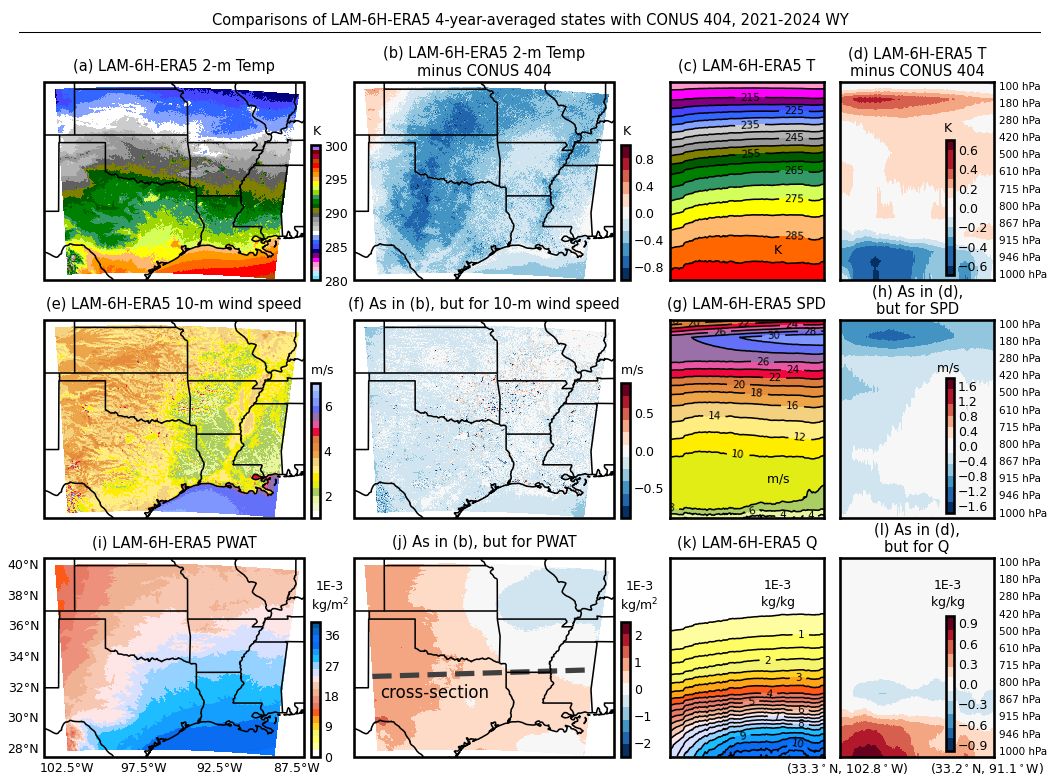

In [17]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

clabel_fmt_base = {'WRF_T': '%.0f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}
clabel_fmt_diff = {'WRF_T': '%.1f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}

dict_LIMs = {'WRF_T2': [280, 300], 'WRF_SPD10': [1, 7], 'WRF_PWAT': [0, 0.04]}
dict_diff_LIMs = {'WRF_T2': [-1, 1], 'WRF_SPD10': [-0.9, 0.9], 'WRF_PWAT': [-0.0025, 0.0025]}
dict_levels = {'WRF_T': np.arange(195, 315, 5), 'WRF_SPD': np.arange(0, 38, 2), 'WRF_Q_tot': np.arange(0, 0.012+0.0005, 0.0005)}
dict_diff_levels = {'WRF_T': np.arange(-0.7, 0.8, 0.1), 'WRF_SPD': np.arange(-1.8, 1.9, 0.1), 'WRF_Q_tot': np.arange(-0.001, 0.00105, 0.00005)}

dict_CMAPs = {'WRF_T2': cmaps.t2m_29lev, 'WRF_T': cmaps.t2m_29lev, 'WRF_SPD10': cmaps.wind_17lev, 'WRF_SPD': cmaps.wind_17lev, 'WRF_PWAT': cmaps.rh_19lev, 'WRF_Q_tot': cmaps.rh_19lev}
dict_diff_CMAPs = {'WRF_T2': cmaps.CBR_coldhot, 'WRF_T': cmaps.CBR_coldhot, 'WRF_SPD10': cmaps.CBR_coldhot, 'WRF_SPD': cmaps.CBR_coldhot, 'WRF_PWAT': cmaps.CBR_coldhot, 'WRF_Q_tot': cmaps.CBR_coldhot}

dict_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}
dict_diff_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}

exp_name = 'B6H'
exp_name_print = 'LAM-6H-ERA5'

fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(5, 7, height_ratios=[1, 0.2, 1, 0.2, 1], width_ratios=[1, 0.001, 1, 0.1, 0.5, 0.05, 0.5])

AX_maps = []
AX_lines = []

AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 0], projection=proj_))

AX_maps.append(plt.subplot(gs[0, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 2], projection=proj_))


AX_lines.append(plt.subplot(gs[0, 4]))
AX_lines.append(plt.subplot(gs[2, 4]))
AX_lines.append(plt.subplot(gs[4, 4]))

AX_lines.append(plt.subplot(gs[0, 6]))
AX_lines.append(plt.subplot(gs[2, 6]))
AX_lines.append(plt.subplot(gs[4, 6]))

# AX_midline = plt.subplot(gs[:, 3])
# AX_midline.axvline(0.7, ymin=0, ymax=1.1, lw=2.5, color='k')

title_maps = [
    f'(a) {exp_name_print} 2-m Temp', 
    f'(e) {exp_name_print} 10-m wind speed',
    f'(i) {exp_name_print} PWAT',
    f'(b) {exp_name_print} 2-m Temp\nminus CONUS 404', 
    f'(f) As in (b), but for 10-m wind speed',
    f'(j) As in (b), but for PWAT'
]

title_lines = [
    f'(c) {exp_name_print} T', 
    f'(g) {exp_name_print} SPD',
    f'(k) {exp_name_print} Q',
    f'(d) {exp_name_print} T\nminus CONUS 404', 
    f'(h) As in (d),\nbut for SPD',
    f'(l) As in (d),\nbut for Q'
]

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if '\n' in title_maps[i_ax]:
        ax.set_title(title_maps[i_ax], fontsize=14)
    else:
        ax.set_title(title_maps[i_ax], fontsize=14, y=1.025)


i_ax = 2
ax = AX_maps[i_ax]
    
GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color=None, linewidth=0, zorder=5
)

GL.xlabel_style = {'size': 12}
GL.ylabel_style = {'size': 12}
GL.top_labels = None
GL.right_labels = None

for i_ax, ax in enumerate(AX_lines):
    ax = gu.ax_decorate_box(ax)
    if '\n' in title_lines[i_ax]:
        ax.set_title(title_lines[i_ax], fontsize=14)
    else:
        ax.set_title(title_lines[i_ax], fontsize=14, y=1.025)
        
    ax = ax.invert_yaxis()

plt.subplots_adjust(0, 0, 1, 1, hspace=0., wspace=0.0)


CS = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM = dict_LIMs[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}']
    f = dict_factor[varname]
    cs_ = AX_maps[i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM[0], vmax=f*LIM[1], cmap=CMAP, transform=ccrs.PlateCarree())
    CS.append(cs_)
    
CS_diff = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM_diff = dict_diff_LIMs[varname]
    CMAP_diff = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'] - dict_clim[f'target_{varname}']
    f = dict_diff_factor[varname]
    cs_ = AX_maps[3+i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM_diff[0], vmax=f*LIM_diff[1], cmap=CMAP_diff, transform=ccrs.PlateCarree())
    CS_diff.append(cs_)

AX_maps[5].plot(lon_range, lat_range-0.2, ls='--', color='0.25', lw=5, transform=ccrs.PlateCarree())
AX_maps[5].text(0.1, 0.365, 'cross-section', ha='left', va='top', fontsize=16, transform=AX_maps[5].transAxes)

for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_levels[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]
    f = dict_factor[varname]
    
    AX_lines[i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    step = max(1, len(levels_)//12)
    cs_lines = AX_lines[i_var].contour(gridx, gridy, f*data, levels=f*levels_, colors='k', linewidths=1.5)
    AX_lines[i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

CS_profile = []
for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_diff_levels[varname]
    CMAP = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]-dict_clim[f'target_{varname}'][:, 150, :]
    f = dict_diff_factor[varname]
    
    cs_ = AX_lines[3+i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    CS_profile.append(cs_)
    # step = max(1, len(levels_)//12)
    # cs_lines = AX_lines[3+i_var].contour(gridx, gridy, data, levels=levels_, colors='k', linewidths=1.5)
    # AX_lines[3+i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

locx_label = 1.03
locy_label = np.linspace(0.0, 0.95, 12)

for ax in AX_lines[3:]:
    for i_p, p in enumerate(plevel):
        ax.text(locx_label, locy_label[i_p], f'{int(p)} hPa', fontsize=10, ha='left', va='bottom', transform=ax.transAxes)
    
# ----------------------------------------------------------------------------------- #
pad_ = 0.0075
loc_x = [0.292+pad_, 0.61+pad_, 0.95]
loc_y = [0.7055, 0.353, 0.0]

ax_base1 = fig.add_axes([loc_x[0], loc_y[0], 0.03, 0.2])
ax_base1.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS[0], orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)
# CBar1.ax.set_xlabel('2-m Temp [K]', fontsize=14)

ax_base1_diff = fig.add_axes([loc_x[1], loc_y[0], 0.03, 0.2])
ax_base1_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_diff = inset_axes(ax_base1_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar1_diff = plt.colorbar(CS_diff[0], orientation='vertical', cax=cax1_diff)
CBar1_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1_diff.ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
CBar1_diff.outline.set_linewidth(2.5)
# CBar1_diff.ax.set_xlabel('2-m Temp diff', fontsize=14)

ax_base1_profile = fig.add_axes([loc_x[2], loc_y[0]+pad_, 0.03, 0.2])
ax_base1_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_profile = inset_axes(ax_base1_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar1_profile = plt.colorbar(CS_profile[0], orientation='vertical', cax=cax1_profile)
CBar1_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
# CBar1_profile.ax.set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
CBar1_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
ax_base2 = fig.add_axes([loc_x[0], loc_y[1], 0.03, 0.2])
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS[1], orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
# CBar2.ax.set_xlabel('10-m wind speed [$\mathsf{m^2s^{-2}}$]', fontsize=14)

ax_base2_diff = fig.add_axes([loc_x[1], loc_y[1], 0.03, 0.2])
ax_base2_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_diff = inset_axes(ax_base2_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar2_diff = plt.colorbar(CS_diff[1], orientation='vertical', cax=cax2_diff)
CBar2_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_diff.outline.set_linewidth(2.5)
# CBar2_diff.ax.set_xlabel('10-m wind speed diff', fontsize=14)

ax_base2_profile = fig.add_axes([loc_x[2], loc_y[1]+pad_, 0.03, 0.2])
ax_base2_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_profile = inset_axes(ax_base2_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar2_profile = plt.colorbar(CS_profile[1], orientation='vertical', cax=cax2_profile)
CBar2_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_profile.outline.set_linewidth(2.5)


# ----------------------------------------------------------------------------------- #
ax_base3 = fig.add_axes([loc_x[0], loc_y[2], 0.03, 0.2])
ax_base3.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3 = inset_axes(ax_base3, height='100%', width='30%', borderpad=0, loc=2)
CBar3 = plt.colorbar(CS[2], orientation='vertical', cax=cax3)
CBar3.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3.ax.set_yticks([0, 9, 18, 27, 36])
CBar3.outline.set_linewidth(2.5)
# CBar3.ax.set_xlabel('PWAT [$\mathsf{kg\cdot m^{-2}}$]', fontsize=14)

ax_base3_diff = fig.add_axes([loc_x[1], loc_y[2], 0.03, 0.2])
ax_base3_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_diff = inset_axes(ax_base3_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar3_diff = plt.colorbar(CS_diff[2], orientation='vertical', cax=cax3_diff)
CBar3_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3_diff.outline.set_linewidth(2.5)
# CBar3_diff.ax.set_xlabel('PWAT diff', fontsize=14)

ax_base3_profile = fig.add_axes([loc_x[2], loc_y[2]+pad_, 0.03, 0.2])
ax_base3_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_profile = inset_axes(ax_base3_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar3_profile = plt.colorbar(CS_profile[2], orientation='vertical', cax=cax3_profile)
CBar3_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3_profile.ax.set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
CBar3_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
text_units = [
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$', 
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$'
]
loc_unit_x = [1.05, 1.07, 1.1]*2
loc_unit_y = [0.75, 0.75, 0.8]*2
for i_text, text_unit in enumerate(text_units):
    AX_maps[i_text].text(loc_unit_x[i_text], loc_unit_y[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_maps[i_text].transAxes)


text_units_3 = ['K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/kg}$']
loc_unit_y_3 = [0.765, 0.76, 0.815]
for i_text, text_unit in enumerate(text_units_3):
    AX_lines[3+i_text].text(0.7, loc_unit_y_3[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_lines[3+i_text].transAxes)

AX_lines[0].text(0.7, 0.15, 'K', ha='center', va='center', fontsize=12, transform=AX_lines[0].transAxes)
AX_lines[1].text(0.7, 0.2, '$\mathsf{m/s}$', ha='center', va='center', fontsize=12, transform=AX_lines[1].transAxes)
AX_lines[2].text(0.7, 0.815, '1E-3\n$\mathsf{kg/kg}$', ha='center', va='center', fontsize=12, transform=AX_lines[2].transAxes)

AX_lines[-1].text(0.05, -0.02, '(33.3$^\circ$N, 102.8$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)
AX_lines[-1].text(0.95, -0.02, '(33.2$^\circ$N, 91.1$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)

ax_title1 = fig.add_axes([0.0, 1.07, 1.0475, 0.04])

ax_title1.text(
    0.5, 0.5, 
    f'Comparisons of {exp_name_print} 4-year-averaged states with CONUS 404, 2021-2024 WY', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.axhline(y=0.1, lw=1, ls='-', color='k')

ax_title1.set_axis_off()
ax_base1.set_axis_off()
ax_base1_diff.set_axis_off()
ax_base1_profile.set_axis_off()
ax_base2.set_axis_off()
ax_base2_diff.set_axis_off()
ax_base2_profile.set_axis_off()
ax_base3.set_axis_off()
ax_base3_diff.set_axis_off()
ax_base3_profile.set_axis_off()

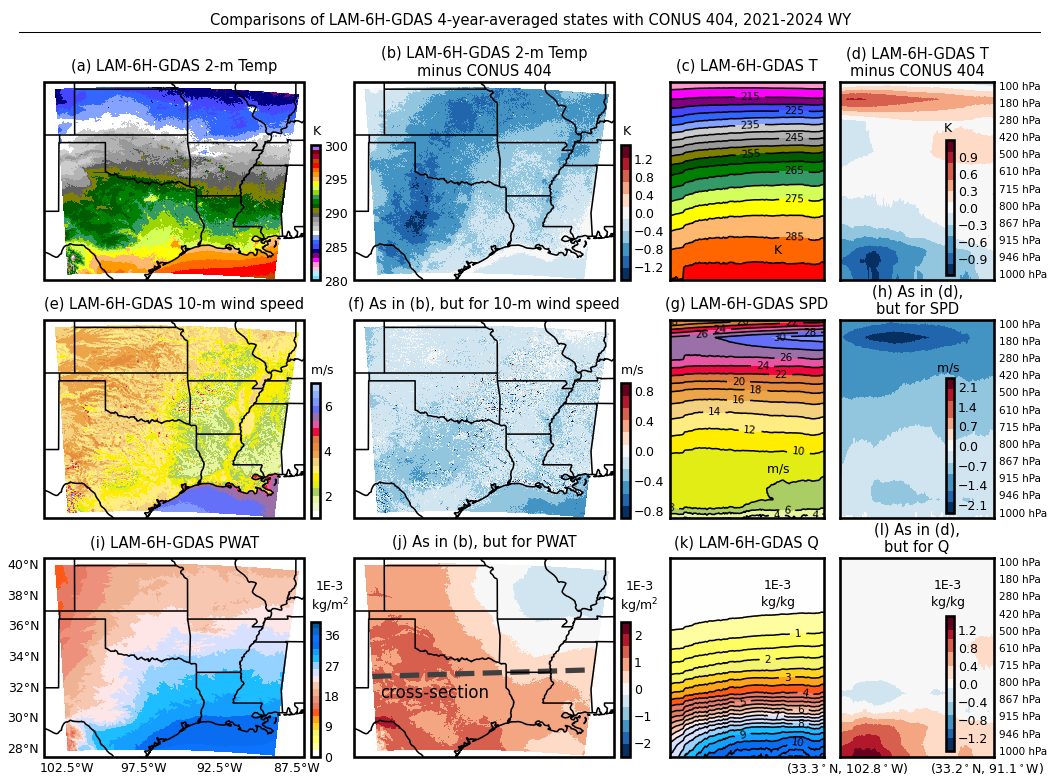

In [18]:
proj_ = ccrs.PlateCarree()
map_extent = [-104, -87, 27.5, 40.5]

clabel_fmt_base = {'WRF_T': '%.0f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}
clabel_fmt_diff = {'WRF_T': '%.1f', 'WRF_SPD': '%.0f', 'WRF_Q_tot': '%.0f'}

dict_LIMs = {'WRF_T2': [280, 300], 'WRF_SPD10': [1, 7], 'WRF_PWAT': [0, 0.04]}
dict_diff_LIMs = {'WRF_T2': [-1.5, 1.5], 'WRF_SPD10': [-0.9, 0.9], 'WRF_PWAT': [-0.0025, 0.0025]}
dict_levels = {'WRF_T': np.arange(195, 315, 5), 'WRF_SPD': np.arange(0, 38, 2), 'WRF_Q_tot': np.arange(0, 0.012+0.0005, 0.0005)}
dict_diff_levels = {'WRF_T': np.arange(-1.2, 1.3, 0.1), 'WRF_SPD': np.arange(-2.4, 2.6, 0.2), 'WRF_Q_tot': np.arange(-0.0015, 0.0016, 0.0001)}

dict_CMAPs = {'WRF_T2': cmaps.t2m_29lev, 'WRF_T': cmaps.t2m_29lev, 'WRF_SPD10': cmaps.wind_17lev, 'WRF_SPD': cmaps.wind_17lev, 'WRF_PWAT': cmaps.rh_19lev, 'WRF_Q_tot': cmaps.rh_19lev}
dict_diff_CMAPs = {'WRF_T2': cmaps.CBR_coldhot, 'WRF_T': cmaps.CBR_coldhot, 'WRF_SPD10': cmaps.CBR_coldhot, 'WRF_SPD': cmaps.CBR_coldhot, 'WRF_PWAT': cmaps.CBR_coldhot, 'WRF_Q_tot': cmaps.CBR_coldhot}

dict_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}
dict_diff_factor = {'WRF_T2': 1.0, 'WRF_T': 1.0, 'WRF_SPD10': 1.0, 'WRF_SPD': 1.0, 'WRF_PWAT':1e3, 'WRF_Q_tot':1e3}

exp_name = 'GDAS'
exp_name_print = 'LAM-6H-GDAS'

fig = plt.figure(figsize=(13, 9), dpi=dpi_)
gs = gridspec.GridSpec(5, 7, height_ratios=[1, 0.2, 1, 0.2, 1], width_ratios=[1, 0.001, 1, 0.1, 0.5, 0.05, 0.5])

AX_maps = []
AX_lines = []

AX_maps.append(plt.subplot(gs[0, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 0], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 0], projection=proj_))

AX_maps.append(plt.subplot(gs[0, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[2, 2], projection=proj_))
AX_maps.append(plt.subplot(gs[4, 2], projection=proj_))


AX_lines.append(plt.subplot(gs[0, 4]))
AX_lines.append(plt.subplot(gs[2, 4]))
AX_lines.append(plt.subplot(gs[4, 4]))

AX_lines.append(plt.subplot(gs[0, 6]))
AX_lines.append(plt.subplot(gs[2, 6]))
AX_lines.append(plt.subplot(gs[4, 6]))

# AX_midline = plt.subplot(gs[:, 3])
# AX_midline.axvline(0.7, ymin=0, ymax=1.1, lw=2.5, color='k')

title_maps = [
    f'(a) {exp_name_print} 2-m Temp', 
    f'(e) {exp_name_print} 10-m wind speed',
    f'(i) {exp_name_print} PWAT',
    f'(b) {exp_name_print} 2-m Temp\nminus CONUS 404', 
    f'(f) As in (b), but for 10-m wind speed',
    f'(j) As in (b), but for PWAT'
]

title_lines = [
    f'(c) {exp_name_print} T', 
    f'(g) {exp_name_print} SPD',
    f'(k) {exp_name_print} Q',
    f'(d) {exp_name_print} T\nminus CONUS 404', 
    f'(h) As in (d),\nbut for SPD',
    f'(l) As in (d),\nbut for Q'
]

for i_ax, ax in enumerate(AX_maps):
    ax.set_extent(map_extent, crs=proj_)
    ax = map_gridline_opt(ax)
    if '\n' in title_maps[i_ax]:
        ax.set_title(title_maps[i_ax], fontsize=14)
    else:
        ax.set_title(title_maps[i_ax], fontsize=14, y=1.025)


i_ax = 2
ax = AX_maps[i_ax]
    
GL = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True, x_inline=False, y_inline=False, 
    color=None, linewidth=0, zorder=5
)

GL.xlabel_style = {'size': 12}
GL.ylabel_style = {'size': 12}
GL.top_labels = None
GL.right_labels = None

for i_ax, ax in enumerate(AX_lines):
    ax = gu.ax_decorate_box(ax)
    if '\n' in title_lines[i_ax]:
        ax.set_title(title_lines[i_ax], fontsize=14)
    else:
        ax.set_title(title_lines[i_ax], fontsize=14, y=1.025)
        
    ax = ax.invert_yaxis()

plt.subplots_adjust(0, 0, 1, 1, hspace=0., wspace=0.0)


CS = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM = dict_LIMs[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}']
    f = dict_factor[varname]
    cs_ = AX_maps[i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM[0], vmax=f*LIM[1], cmap=CMAP, transform=ccrs.PlateCarree())
    CS.append(cs_)
    
CS_diff = []
for i_var, varname in enumerate(['WRF_T2', 'WRF_SPD10', 'WRF_PWAT']):
    LIM_diff = dict_diff_LIMs[varname]
    CMAP_diff = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'] - dict_clim[f'target_{varname}']
    f = dict_diff_factor[varname]
    cs_ = AX_maps[3+i_var].pcolormesh(lon_WRF, lat_WRF, f*data, vmin=f*LIM_diff[0], vmax=f*LIM_diff[1], cmap=CMAP_diff, transform=ccrs.PlateCarree())
    CS_diff.append(cs_)

AX_maps[5].plot(lon_range, lat_range-0.2, ls='--', color='0.25', lw=5, transform=ccrs.PlateCarree())
AX_maps[5].text(0.1, 0.365, 'cross-section', ha='left', va='top', fontsize=16, transform=AX_maps[5].transAxes)

for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_levels[varname]
    CMAP = dict_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]
    f = dict_factor[varname]
    
    AX_lines[i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    step = max(1, len(levels_)//12)
    cs_lines = AX_lines[i_var].contour(gridx, gridy, f*data, levels=f*levels_, colors='k', linewidths=1.5)
    AX_lines[i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

CS_profile = []
for i_var, varname in enumerate(['WRF_T', 'WRF_SPD', 'WRF_Q_tot']):
    levels_ = dict_diff_levels[varname]
    CMAP = dict_diff_CMAPs[varname]
    data = dict_clim[f'{exp_name}_{varname}'][:, 150, :]-dict_clim[f'target_{varname}'][:, 150, :]
    f = dict_diff_factor[varname]
    
    cs_ = AX_lines[3+i_var].contourf(gridx, gridy, f*data, levels=f*levels_, cmap=CMAP)
    CS_profile.append(cs_)
    # step = max(1, len(levels_)//12)
    # cs_lines = AX_lines[3+i_var].contour(gridx, gridy, data, levels=levels_, colors='k', linewidths=1.5)
    # AX_lines[3+i_var].clabel(cs_lines, levels=cs_lines.levels[::step], fmt=clabel_fmt_base[varname], inline=True, fontsize=10)

locx_label = 1.03
locy_label = np.linspace(0.0, 0.95, 12)

for ax in AX_lines[3:]:
    for i_p, p in enumerate(plevel):
        ax.text(locx_label, locy_label[i_p], f'{int(p)} hPa', fontsize=10, ha='left', va='bottom', transform=ax.transAxes)
    
# ----------------------------------------------------------------------------------- #
pad_ = 0.0075
loc_x = [0.292+pad_, 0.61+pad_, 0.95]
loc_y = [0.7055, 0.353, 0.0]

ax_base1 = fig.add_axes([loc_x[0], loc_y[0], 0.03, 0.2])
ax_base1.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1 = inset_axes(ax_base1, height='100%', width='30%', borderpad=0, loc=2)
CBar1 = plt.colorbar(CS[0], orientation='vertical', cax=cax1)
CBar1.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1.outline.set_linewidth(2.5)
# CBar1.ax.set_xlabel('2-m Temp [K]', fontsize=14)

ax_base1_diff = fig.add_axes([loc_x[1], loc_y[0], 0.03, 0.2])
ax_base1_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_diff = inset_axes(ax_base1_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar1_diff = plt.colorbar(CS_diff[0], orientation='vertical', cax=cax1_diff)
CBar1_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1_diff.ax.set_yticks([-1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2])
CBar1_diff.outline.set_linewidth(2.5)
# CBar1_diff.ax.set_xlabel('2-m Temp diff', fontsize=14)

ax_base1_profile = fig.add_axes([loc_x[2], loc_y[0]+pad_, 0.03, 0.2])
ax_base1_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax1_profile = inset_axes(ax_base1_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar1_profile = plt.colorbar(CS_profile[0], orientation='vertical', cax=cax1_profile)
CBar1_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar1_profile.ax.set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
CBar1_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
ax_base2 = fig.add_axes([loc_x[0], loc_y[1], 0.03, 0.2])
ax_base2.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2 = inset_axes(ax_base2, height='100%', width='30%', borderpad=0, loc=2)
CBar2 = plt.colorbar(CS[1], orientation='vertical', cax=cax2)
CBar2.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2.outline.set_linewidth(2.5)
# CBar2.ax.set_xlabel('10-m wind speed [$\mathsf{m^2s^{-2}}$]', fontsize=14)

ax_base2_diff = fig.add_axes([loc_x[1], loc_y[1], 0.03, 0.2])
ax_base2_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_diff = inset_axes(ax_base2_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar2_diff = plt.colorbar(CS_diff[1], orientation='vertical', cax=cax2_diff)
CBar2_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_diff.ax.set_yticks([-0.8, -0.4, 0, 0.4, 0.8])
CBar2_diff.outline.set_linewidth(2.5)
# CBar2_diff.ax.set_xlabel('10-m wind speed diff', fontsize=14)

ax_base2_profile = fig.add_axes([loc_x[2], loc_y[1]+pad_, 0.03, 0.2])
ax_base2_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False)
cax2_profile = inset_axes(ax_base2_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar2_profile = plt.colorbar(CS_profile[1], orientation='vertical', cax=cax2_profile)
CBar2_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar2_profile.ax.set_yticks([-2.1, -1.4, -0.7, 0, 0.7, 1.4, 2.1])
CBar2_profile.outline.set_linewidth(2.5)


# ----------------------------------------------------------------------------------- #
ax_base3 = fig.add_axes([loc_x[0], loc_y[2], 0.03, 0.2])
ax_base3.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3 = inset_axes(ax_base3, height='100%', width='30%', borderpad=0, loc=2)
CBar3 = plt.colorbar(CS[2], orientation='vertical', cax=cax3)
CBar3.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3.ax.set_yticks([0, 9, 18, 27, 36])
CBar3.outline.set_linewidth(2.5)
# CBar3.ax.set_xlabel('PWAT [$\mathsf{kg\cdot m^{-2}}$]', fontsize=14)

ax_base3_diff = fig.add_axes([loc_x[1], loc_y[2], 0.03, 0.2])
ax_base3_diff.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_diff = inset_axes(ax_base3_diff, height='100%', width='30%', borderpad=0, loc=2)
CBar3_diff = plt.colorbar(CS_diff[2], orientation='vertical', cax=cax3_diff)
CBar3_diff.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
CBar3_diff.outline.set_linewidth(2.5)
# CBar3_diff.ax.set_xlabel('PWAT diff', fontsize=14)

ax_base3_profile = fig.add_axes([loc_x[2], loc_y[2]+pad_, 0.03, 0.2])
ax_base3_profile.tick_params(
    axis='both', left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cax3_profile = inset_axes(ax_base3_profile, height='100%', width='30%', borderpad=0, loc=2)
CBar3_profile = plt.colorbar(CS_profile[2], orientation='vertical', cax=cax3_profile)
CBar3_profile.ax.tick_params(axis='y', labelsize=12, direction='in', length=0)
# CBar3_profile.ax.set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
CBar3_profile.outline.set_linewidth(2.5)

# ----------------------------------------------------------------------------------- #
text_units = [
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$', 
    'K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/m^{2}}$'
]
loc_unit_x = [1.05, 1.07, 1.1]*2
loc_unit_y = [0.75, 0.75, 0.8]*2
for i_text, text_unit in enumerate(text_units):
    AX_maps[i_text].text(loc_unit_x[i_text], loc_unit_y[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_maps[i_text].transAxes)


text_units_3 = ['K', '$\mathsf{m/s}$', '1E-3\n$\mathsf{kg/kg}$']
loc_unit_y_3 = [0.765, 0.76, 0.815]
for i_text, text_unit in enumerate(text_units_3):
    AX_lines[3+i_text].text(0.7, loc_unit_y_3[i_text], text_unit, ha='center', va='center', fontsize=12, transform=AX_lines[3+i_text].transAxes)

AX_lines[0].text(0.7, 0.15, 'K', ha='center', va='center', fontsize=12, transform=AX_lines[0].transAxes)
AX_lines[1].text(0.7, 0.25, '$\mathsf{m/s}$', ha='center', va='center', fontsize=12, transform=AX_lines[1].transAxes)
AX_lines[2].text(0.7, 0.815, '1E-3\n$\mathsf{kg/kg}$', ha='center', va='center', fontsize=12, transform=AX_lines[2].transAxes)

AX_lines[-1].text(0.05, -0.02, '(33.3$^\circ$N, 102.8$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)
AX_lines[-1].text(0.95, -0.02, '(33.2$^\circ$N, 91.1$^\circ$W)', ha='center', va='top', fontsize=12, transform=AX_lines[-1].transAxes)

ax_title1 = fig.add_axes([0.0, 1.07, 1.0475, 0.04])

ax_title1.text(
    0.5, 0.5, 
    f'Comparisons of {exp_name_print} 4-year-averaged states with CONUS 404, 2021-2024 WY', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.axhline(y=0.1, lw=1, ls='-', color='k')

ax_title1.set_axis_off()
ax_base1.set_axis_off()
ax_base1_diff.set_axis_off()
ax_base1_profile.set_axis_off()
ax_base2.set_axis_off()
ax_base2_diff.set_axis_off()
ax_base2_profile.set_axis_off()
ax_base3.set_axis_off()
ax_base3_diff.set_axis_off()
ax_base3_profile.set_axis_off()